# Data prepping 

In [242]:
import math
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [142]:
def clean_up_nans(data):

  data["PoolQC"].fillna(value = "na", inplace=True)
  data["MiscFeature"].fillna(value = "na", inplace=True)
  data["Alley"].fillna(value = "na", inplace=True)
  data["Fence"].fillna(value = "na", inplace=True)
  data["FireplaceQu"].fillna(value = "na", inplace=True)
  data["GarageCond"].fillna(value = "na", inplace=True)
  data["GarageType"].fillna(value = "na", inplace=True)
  data["GarageFinish"].fillna(value = "na", inplace=True)
  data["GarageQual"].fillna(value = "na", inplace=True)
  data["BsmtFinType2"].fillna(value = "na", inplace=True)
  data["BsmtExposure"].fillna(value = "na", inplace=True)
  data["BsmtQual"].fillna(value = "na", inplace=True)
  data["BsmtCond"].fillna(value = "na", inplace=True)
  data["BsmtFinType1"].fillna(value = "na", inplace=True)
  data["MasVnrType"].fillna(value = "na", inplace=True)

  # seems LotFrontage nans are some sort of error, likely could do better but
  # for now just replace these with a median
  data["LotFrontage"].fillna(value = data["LotFrontage"].median(),inplace = True)
  data["GarageYrBlt"].fillna(value = data["GarageYrBlt"].median(),inplace = True)
  data["MasVnrArea"].fillna(value = data["MasVnrArea"].median(),inplace = True)
  data["Electrical"].fillna(value = "FuseA",inplace = True)
  return data

In [181]:
train = pd.read_csv("train.csv")

In [187]:
housing_data = clean_up_nans(train)

In [176]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [188]:
housing_prices = housing_data["SalePrice"]
housing_data = housing_data.drop("SalePrice",axis=1)
housing_prices_mean = housing_prices.mean()
housing_prices = housing_prices/housing_prices_mean

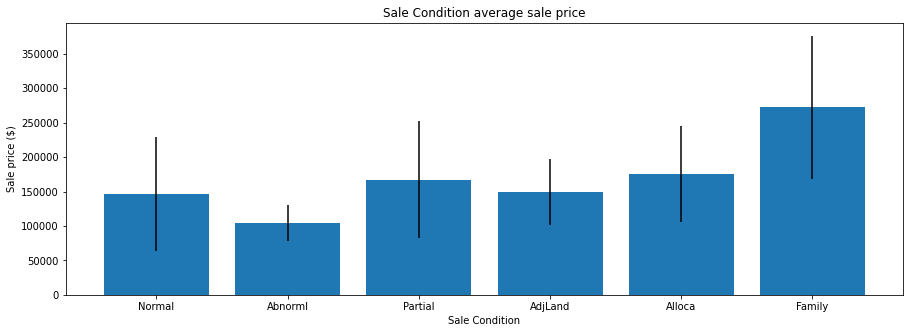

In [146]:
plt.title("Sale Condition average sale price")
plt.ylabel("Sale price ($)")
plt.xlabel("Sale Condition")
#plt.legend(loc='upper right')
plt.bar(housing_data["SaleCondition"].unique(),
        housing_data[["SaleCondition","SalePrice"]].groupby("SaleCondition").mean()["SalePrice"],
        yerr=housing_data[["SaleCondition","SalePrice"]].groupby("SaleCondition").std()["SalePrice"]);
plt.rcParams['figure.figsize'] = [15, 5]

Let's examine the data compared to sale price.

In [195]:
hot_list = ["Exterior1st", "Exterior2nd", "RoofMatl", "RoofStyle",
            "HouseStyle", "BldgType", "Condition2", "Condition1",
            "Neighborhood","LotConfig", "MSZoning", "MasVnrType",
            "Foundation", "Heating","GarageType", "Fence", "MiscFeature", "SaleType"]
one_code = []
quant = []
for attr in housing_data.columns:

    if hot_list.count(attr) ==0:
        if housing_data[attr].dtype == "object":
            one_code.append(attr)
        else:
            quant.append(attr)

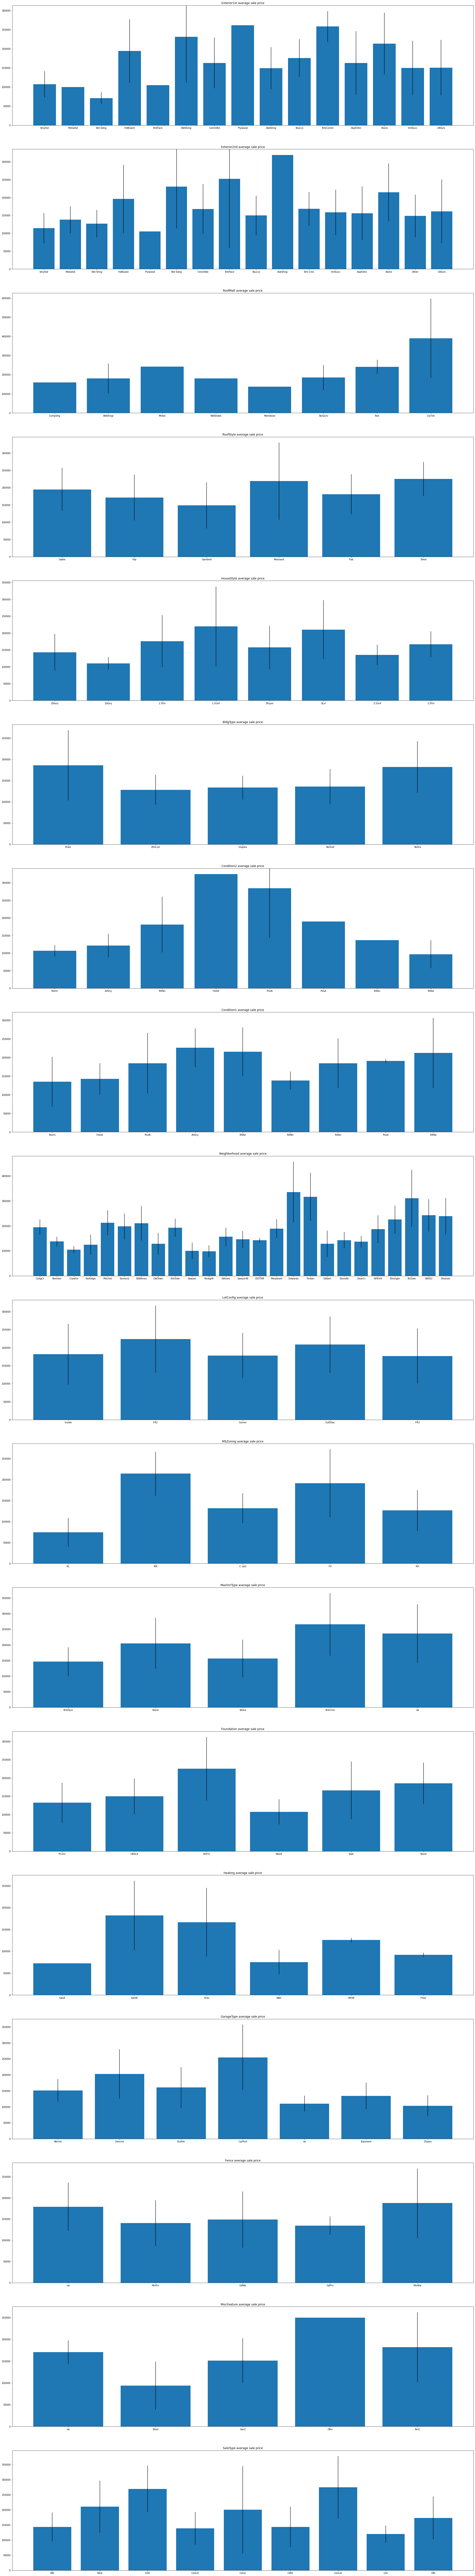

In [148]:
fig, axs = plt.subplots(len(hot_list),figsize=(35,200))
for i in range(len(hot_list)):
    bsmt = hot_list[i]
    axs[i].set_title(bsmt+" average sale price")
    #axs[i].ylabel("Sale price ($)")
    #axs[i].xlabel(bsmt)
    #plt.legend(loc='upper right')
    axs[i].bar(housing_data[bsmt].unique(),
        housing_data[[bsmt,"SalePrice"]].groupby(bsmt).mean()["SalePrice"],
        yerr=housing_data[[bsmt,"SalePrice"]].groupby(bsmt).std()["SalePrice"]);

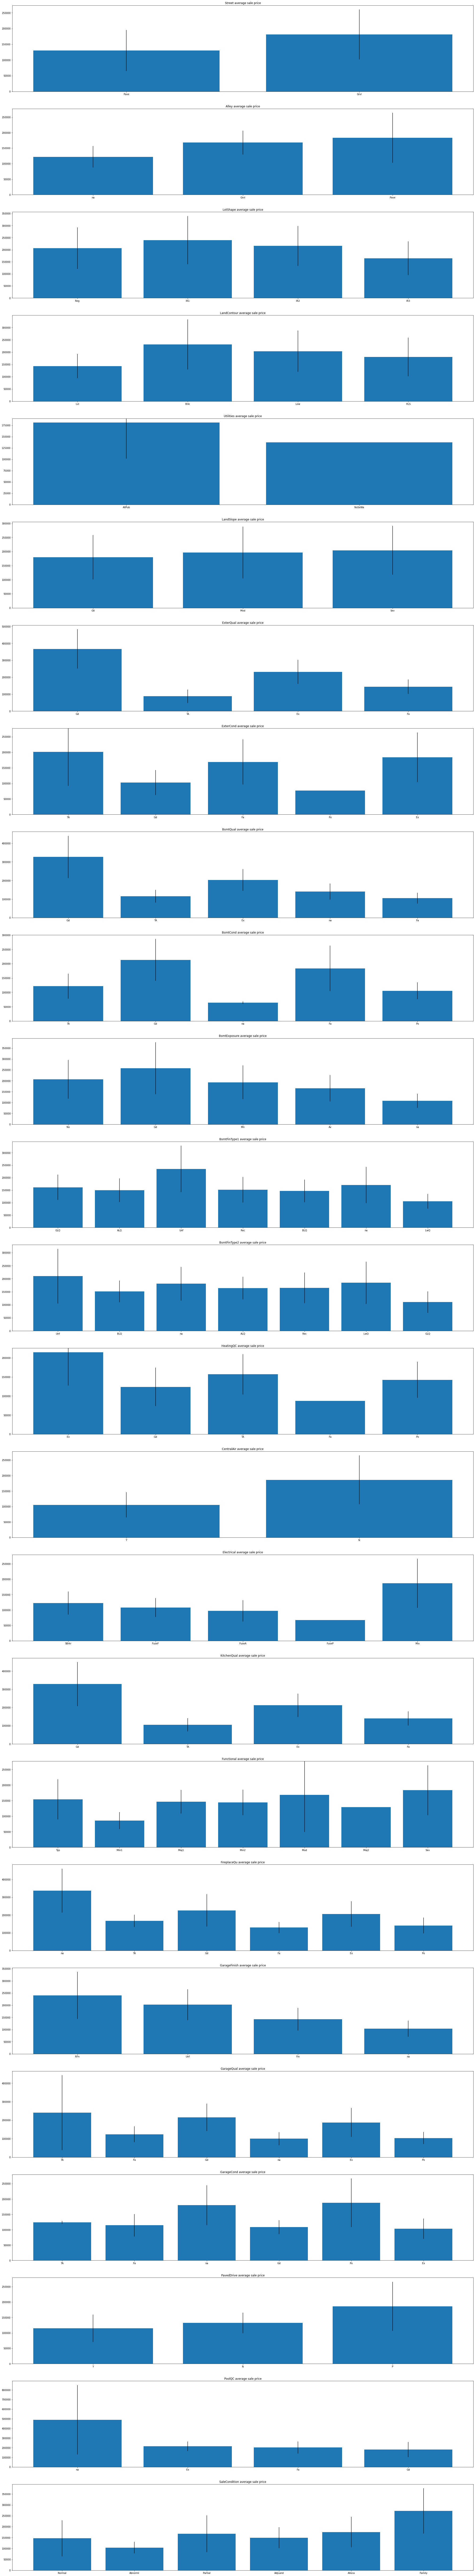

In [111]:
fig, axs = plt.subplots(len(one_code),figsize=(35,200))
for i in range(len(one_code)):
    bsmt = one_code[i]
    axs[i].set_title(bsmt+" average sale price")
    #axs[i].ylabel("Sale price ($)")
    #axs[i].xlabel(bsmt)
    #plt.legend(loc='upper right')
    axs[i].bar(housing_data[bsmt].unique(),
        housing_data[[bsmt,"SalePrice"]].groupby(bsmt).mean()["SalePrice"],
        yerr=housing_data[[bsmt,"SalePrice"]].groupby(bsmt).std()["SalePrice"]);

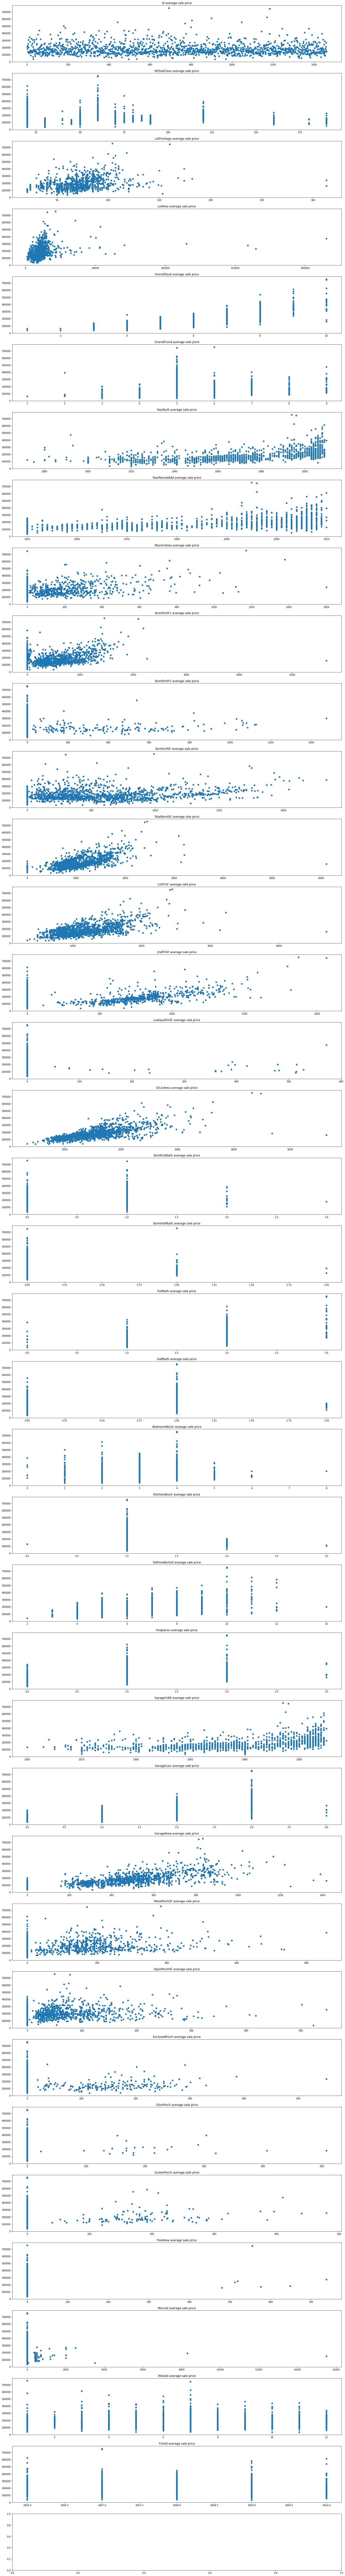

In [149]:
fig, axs = plt.subplots(len(quant),figsize=(25,200))

for i in range(len(quant)-1):
    bsmt = quant[i]
    axs[i].set_title(bsmt+" average sale price")
    #axs[i].ylabel("Sale price ($)")
    #axs[i].xlabel(bsmt)
    #plt.legend(loc='upper right')
    axs[i].plot(housing_data[bsmt],
        housing_data["SalePrice"],marker='o',linewidth=0);

In [196]:
#drop = ["SalePrice"]
#drop = [""]
pipe = [('standard_scaler',StandardScaler(),quant),("categorical",OneHotEncoder(),hot_list),
       ("binary",OrdinalEncoder(),one_code)]
full_pipe = ColumnTransformer(pipe,remainder='passthrough')
train_trans = full_pipe.fit_transform(housing_data)

In [197]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.1, random_state=42)
#housing_data = housing_data.set_index('Id')
for train_ind, test_ind in split.split(housing_data,housing_data["Neighborhood"]):
    train_list = train_ind
    test_list = test_ind

In [198]:
train_data, train_price = train_trans[train_ind], housing_prices[train_ind]
test_data, test_price = train_trans[test_ind], housing_prices[test_ind]


# Create Models

In [157]:
def plot_learning(model,x_train,x_val,y_train,y_val,mean_):


  train_err, val_err,sam_size = [],[],[]
  for i in range(1,len(x_train),100):
    sam_size.append(i)
    model.fit(x_train[:i],y_train[:i])
    y_train_predict = model.predict(x_train[:i])
    y_val_predict = model.predict(x_val)
    train_err.append(mean_squared_error(y_train[:i]*mean_,y_train_predict[:i]*mean_))
    val_err.append(mean_squared_error(y_val*mean_,y_val_predict*mean_))
  plt.axis([0,1500,0,100000])
  plt.ylabel("RMSE")
  plt.xlabel("Data Size")
  plt.title("Learning Rate")


  plt.plot(sam_size,np.sqrt(train_err),"r-+",linewidth=2,label="Training Set")
  plt.plot(sam_size,np.sqrt(val_err),"b-",linewidth=3,label="Validation Set")
  plt.legend()

In [227]:
def plot_fit_results(housing_val_pred,price_val,sale_mean,lin_mse_val):
    
    x_ = range(len(housing_val_pred))
    plt.bar(x_,sale_mean*housing_val_pred,color='red',alpha=0.5,label='prediction')
    plt.bar(x_,sale_mean*price_val,color='blue',alpha=0.5,label='actual')
    plt.ylabel("Prices in $")
    plt.title("Validation Results")
    plt.text(0,4e5,"RMSE= "+str(lin_mse_val))
    plt.legend()
    plt.figure(figsize = (30,50))

## Linear Regression

In [136]:
from sklearn.linear_model import LinearRegression, Ridge

In [137]:
lin_reg = LinearRegression()
ridge_reg = Ridge()

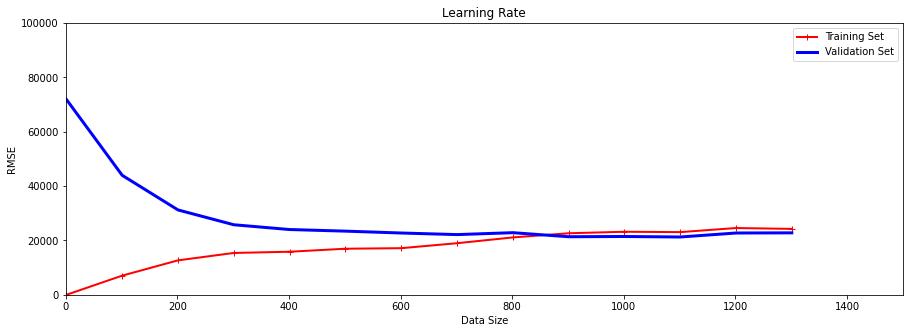

In [199]:
plot_learning(ridge_reg,train_data,test_data,train_price,test_price,housing_prices_mean)

In [210]:
ridge_reg.fit(train_data,train_price)

Ridge()

In [211]:
mse = np.sqrt(mean_squared_error(ridge_reg.predict(test_data),test_price)*housing_prices_mean**2)
print("RMSE =",mse)

RMSE = 22706.48286101771


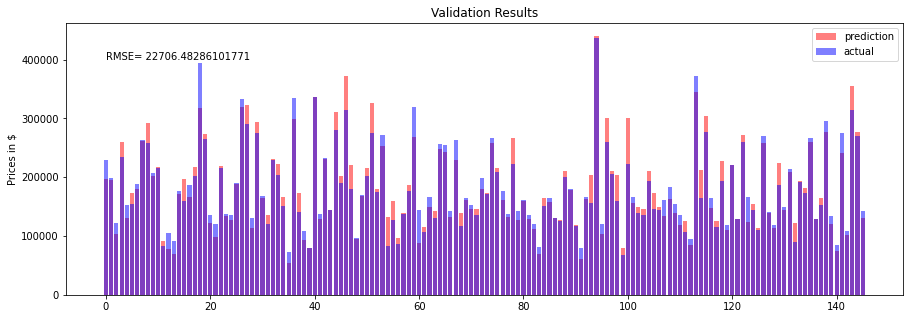

<Figure size 2160x3600 with 0 Axes>

In [228]:
plot_fit_results(ridge_reg.predict(test_data),test_price,housing_prices_mean,mse)

## Random Forest

In [288]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [295]:
rf = RandomForestRegressor()
param_grid = [{'n_estimators': [3,10,15,20,30,40,50,60,70,100,125,150,175], 'max_features':
  [2,4,6,8,10,12,14,16,18,20,30,40,50,100,150,200,250,300]}]

In [296]:
grid_search = GridSearchCV(rf, param_grid, cv=4,scoring='neg_mean_squared_error',return_train_score=True)

In [297]:
grid_search.fit(train_data,train_price)
print(grid_search.best_params_)

{'max_features': 100, 'n_estimators': 40}


In [298]:
rf = RandomForestRegressor(max_features=100,n_estimators=40)
rf.fit(train_data,train_price)

RandomForestRegressor(max_features=100, n_estimators=40)

In [299]:
scores = cross_val_score(rf, train_data,train_price,scoring="neg_mean_squared_error",cv=7)
display_scores(housing_prices_mean*np.sqrt(-scores))

Scores: [32056.10538874 22412.79176844 22787.47435082 35477.28763215
 39912.8693099  20425.82786868 30845.76250222]
Mean: 29131.15983156346
Standard deviation: 6857.481687507533


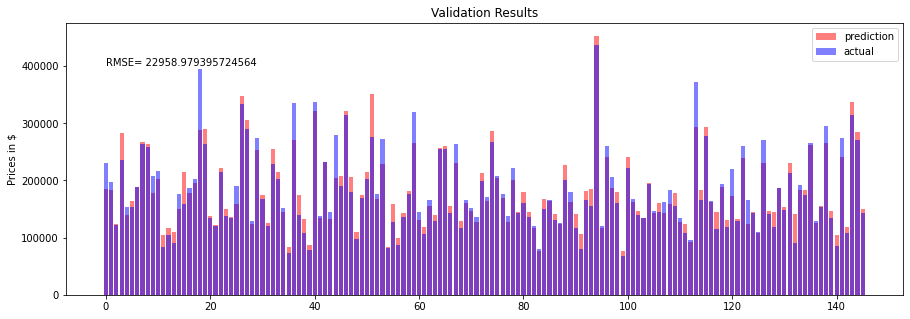

<Figure size 2160x3600 with 0 Axes>

In [300]:
mse = np.sqrt(mean_squared_error(grid_search.predict(test_data),test_price)*housing_prices_mean**2)
plot_fit_results(rf.predict(test_data),test_price,housing_prices_mean,mse)

In [231]:
gb = GradientBoostingRegressor()

In [255]:
param_grid = [{'n_estimators': [3,10,15,20,30,40,50,60,70,100,125,150,175], 'max_features':
  [2,4,6,8,10,12,14,16,18,20]}]

In [256]:
grid_search = GridSearchCV(gb, param_grid, cv=4,scoring='neg_mean_squared_error',return_train_score=True)

In [257]:
grid_search.fit(train_data,train_price)
print(grid_search.best_params_)

{'max_features': 14, 'n_estimators': 125}


In [258]:
scores = cross_val_score(grid_search, train_data,train_price,scoring="neg_mean_squared_error",cv=7)

In [259]:
display_scores(housing_prices_mean*np.sqrt(-scores))

Scores: [33468.62128756 20843.15986607 20276.38233473 33008.34913648
 37117.9736472  22131.28772424 26643.5872479 ]
Mean: 27641.337320597966
Standard deviation: 6373.8597942698825


In [261]:
mse = np.sqrt(mean_squared_error(grid_search.predict(test_data),test_price)*housing_prices_mean**2)

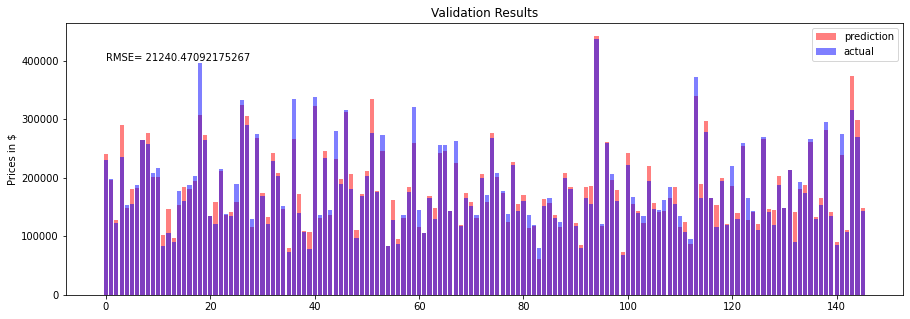

<Figure size 2160x3600 with 0 Axes>

In [262]:
plot_fit_results(grid_search.predict(test_data),test_price,housing_prices_mean,mse)

In [303]:
from xgboost import XGBRegressor

In [319]:
#param_grid =[{'eta':[0.1,0.3,0.5,0.7], 
#              'gamma':[0,1,1e2,1e3],
#              'max_depth':[4,6,8,10],
#              'lambda':[1,10,100],
#              'alpha':[0,1,10,100]}]
param_grid = [{'eta':[0.1,0.3,0.5,0.7],'max_depth':[4,6,8,10],'gamma':[0,1,10]}]

In [320]:
xgb = XGBRegressor()
grid_search = GridSearchCV(xgb, param_grid, cv=5,scoring='neg_mean_squared_error',
                           return_train_score=True)

In [321]:
grid_search.fit(train_data,train_price)
print(grid_search.best_params_)

{'eta': 0.1, 'gamma': 0, 'max_depth': 6}


In [327]:
xgb = XGBRegressor(eta=0.1)
xgb.fit(train_data,train_price)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [325]:
scores = cross_val_score(xgb, train_data,train_price,
                         scoring="neg_mean_squared_error",cv=7)
display_scores(housing_prices_mean*np.sqrt(-scores))

Scores: [32653.97359196 22459.40667935 20482.65879219 35259.06926684
 39089.46036942 20360.42569492 23504.1605374 ]
Mean: 27687.022133153485
Standard deviation: 7195.517089532365


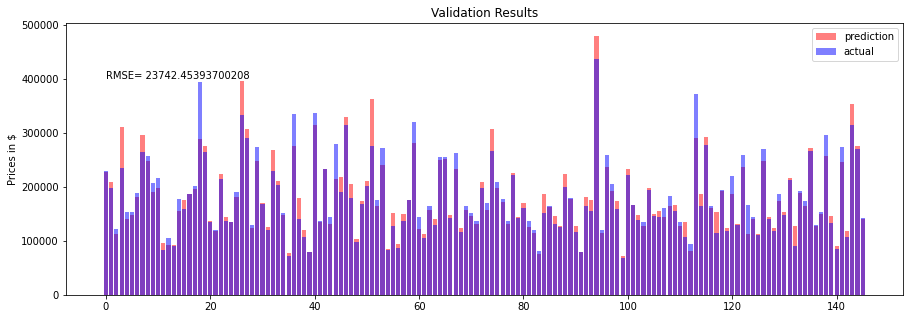

<Figure size 2160x3600 with 0 Axes>

In [328]:
mse = np.sqrt(mean_squared_error(xgb.predict(test_data),test_price)*housing_prices_mean**2)
plot_fit_results(grid_search.predict(test_data),test_price,housing_prices_mean,mse)

## Support vector regressor

In [263]:
from sklearn.svm import SVR

In [264]:
param_grid = [{'C': [1,1e1,1e2,1e3,1e4], 'kernel':['poly'], 'degree':range(3)}]

In [273]:
svr = SVR()

In [276]:
grid_search = GridSearchCV(svr, param_grid, cv=2,scoring='neg_mean_squared_error',return_train_score=True)

In [277]:
grid_search.fit(train_data,train_price)
print(grid_search.best_params_)

{'C': 1, 'degree': 1, 'kernel': 'poly'}


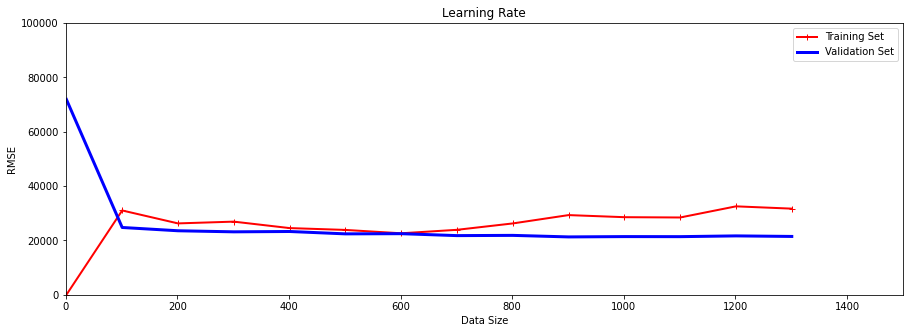

In [337]:
svr = SVR(C=1,kernel="poly",degree=1)
plot_learning(svr,train_data,test_data,train_price,test_price,housing_prices_mean)

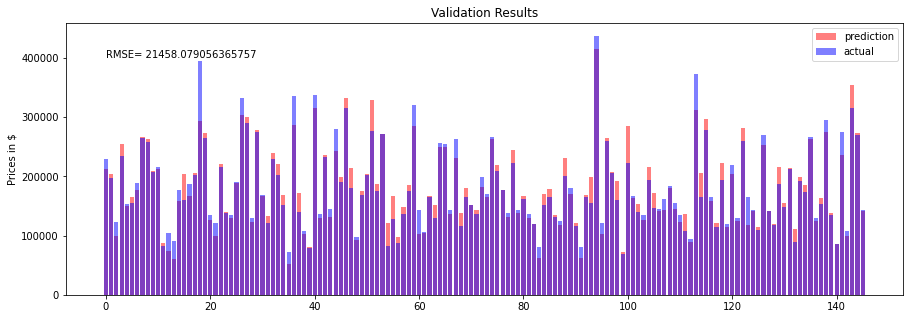

<Figure size 2160x3600 with 0 Axes>

In [338]:
svr.fit(train_data,train_price)
mse = np.sqrt(mean_squared_error(svr.predict(test_data),test_price)*housing_prices_mean**2)
plot_fit_results(svr.predict(test_data),test_price,housing_prices_mean,mse)

## Voting Regressor

In [282]:
from sklearn.ensemble import VotingRegressor

In [284]:
vote = VotingRegressor(estimators= [('ridge',Ridge()),
                                    ('gb',GradientBoostingRegressor(max_features=14, n_estimators= 125)),
                                    ('svr',SVR(C=1,kernel="poly",degree=1))])

VotingRegressor(estimators=[('ridge', Ridge()),
                            ('gb',
                             GradientBoostingRegressor(max_features=14,
                                                       n_estimators=125)),
                            ('svr', SVR(C=1, degree=1, kernel='poly'))])

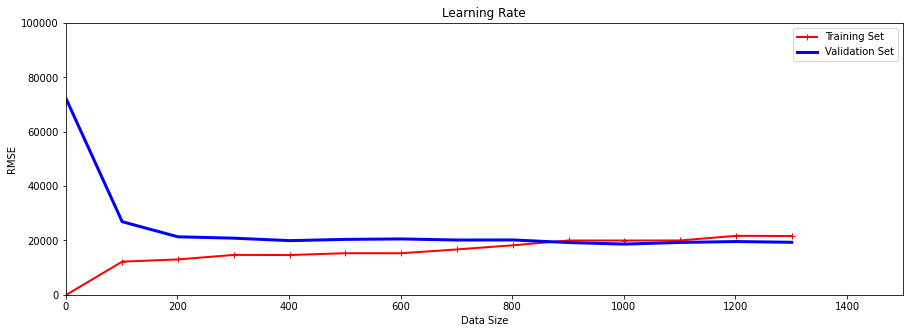

In [286]:
plot_learning(vote,train_data,test_data,train_price,test_price,housing_prices_mean)
vote.fit(train_data,train_price)

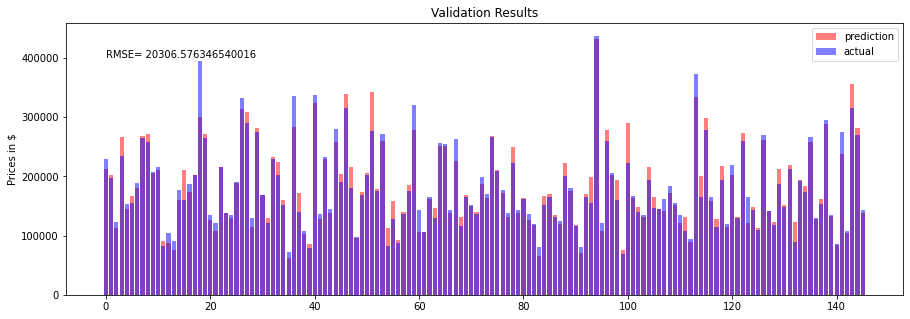

<Figure size 2160x3600 with 0 Axes>

In [287]:
mse = np.sqrt(mean_squared_error(vote.predict(test_data),test_price)*housing_prices_mean**2)
plot_fit_results(vote.predict(test_data),test_price,housing_prices_mean,mse)

## Hybrid

In [332]:
class Boostedhybrid:
    def __init__(self,model1,model2):
        self.model1= model1
        self.model2= model2
        self.y_columns = None

    def fit(self,X,y):
        self.model1.fit(X,y)
        y_fit= self.model1.predict(X)
        y_resid = y-y_fit
        #y_resid = y_resid.stack().squeeze()
        
        self.model2.fit(X,y_resid)

        #self.y_columns=y.columns
        self.y_fit = y_fit
        self.y_resid = y_resid
    def predict(self,X):
        y_pred = self.model1.predict(X)
        y_pred +=self.model2.predict(X)
        return y_pred

In [333]:
hybrid = Boostedhybrid(Ridge(), XGBRegressor())

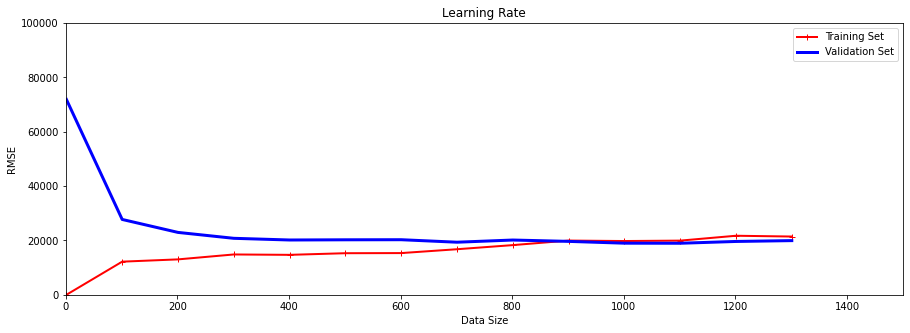

In [335]:
plot_learning(vote,train_data,test_data,train_price,test_price,housing_prices_mean)
hybrid.fit(train_data,train_price)

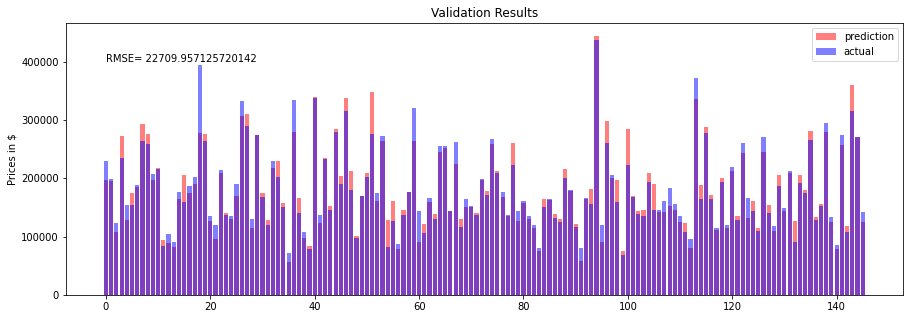

<Figure size 2160x3600 with 0 Axes>

In [336]:
mse = np.sqrt(mean_squared_error(hybrid.predict(test_data),test_price)*housing_prices_mean**2)
plot_fit_results(hybrid.predict(test_data),test_price,housing_prices_mean,mse)

## Stacking

In [340]:
ridge = Ridge()
svr = SVR(C=1,kernel="poly",degree=1)
xgb = XGBRegressor()

In [343]:
ridge.fit(train_data,train_price)
svr.fit(train_data,train_price)
xgb.fit(train_data,train_price)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [350]:
X= np.zeros((len(train_price),3))
X[:,0] += ridge.predict(train_data)
X[:,1] += svr.predict(train_data)
X[:,2] += xgb.predict(train_data)

In [353]:
param_grid = [{'C': [1], 'kernel':['poly'], 'degree':range(5)}]

In [354]:
svr_king = SVR()
grid_search = GridSearchCV(svr_king, param_grid, cv=2,scoring='neg_mean_squared_error',return_train_score=True)

In [355]:
grid_search.fit(X,train_price)
print(grid_search.best_params_)

{'C': 1, 'degree': 1, 'kernel': 'poly'}


In [357]:
X_test= np.zeros((len(test_price),3))
X_test[:,0] += ridge.predict(test_data)
X_test[:,1] += svr.predict(test_data)
X_test[:,2] += xgb.predict(test_data)

Ridge()

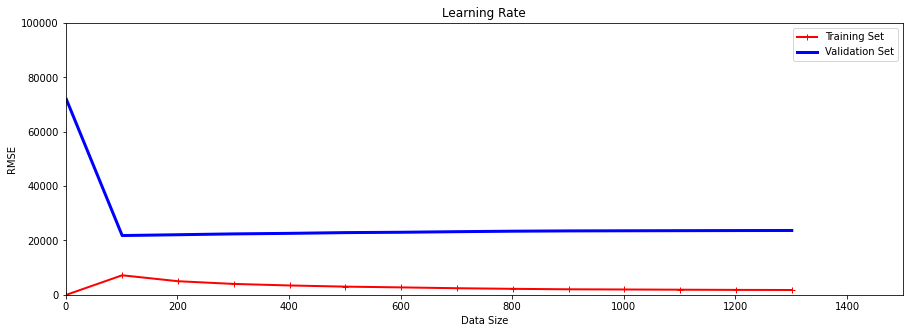

In [372]:
#king = SVR(C=1,kernel='poly',degree=1)
king = Ridge()
#king = RandomForestRegressor()
#king = LinearRegression()
plot_learning(king,X,X_test,train_price,test_price,housing_prices_mean)
king.fit(train_data,train_price)

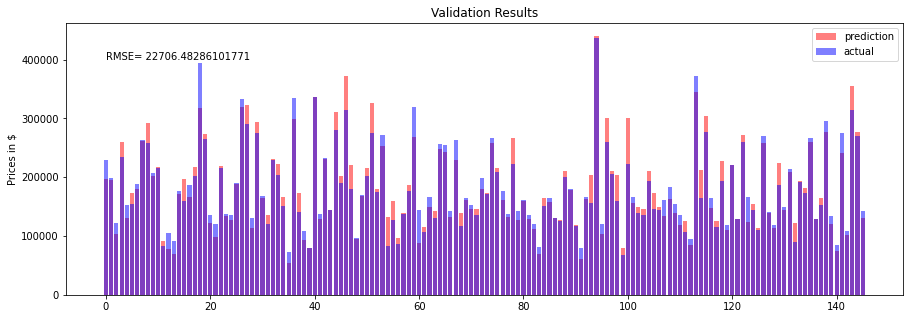

<Figure size 2160x3600 with 0 Axes>

In [373]:
mse = np.sqrt(mean_squared_error(king.predict(test_data),test_price)*housing_prices_mean**2)
plot_fit_results(king.predict(test_data),test_price,housing_prices_mean,mse)

# Check

Many of the models performed quite similarly, in this section we will look for places where the voting model under-performs.

In [377]:
resid = (vote.predict(test_data) - test_price)*housing_prices_mean

IndexError: index 23 is out of bounds for axis 0 with size 23

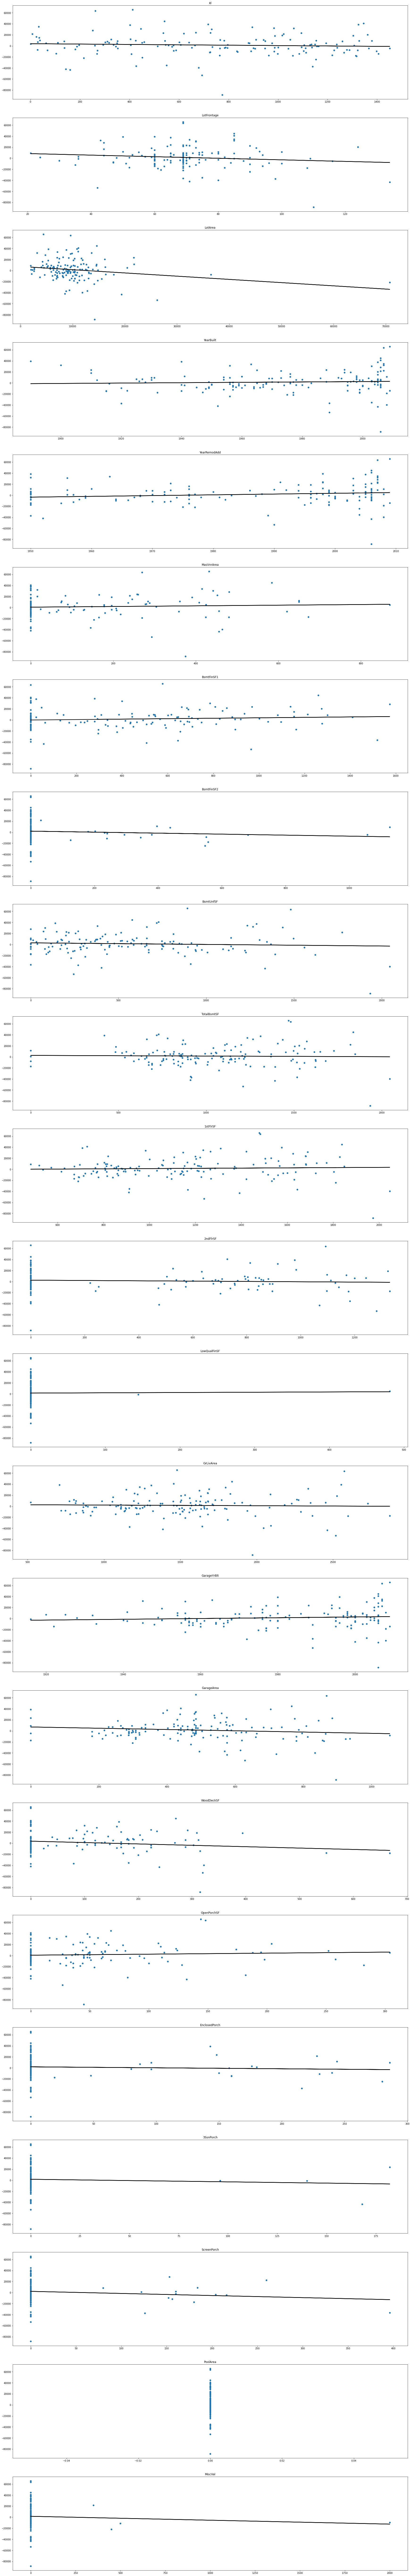

In [396]:
categ =["MSSubClass","OverallQual","OverallCond","BsmtFullBath",
        "BsmtHalfBath","FullBath","HalfBath",
       "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd",
        "Fireplaces","GarageCars","MoSold","Yrsold"]
fig, ax = plt.subplots(len(quant)-len(categ),figsize=(30,200))
c=0
for i in range(len(quant)):
    if quant[i] not in categ:
        x = housing_data[quant[i]].loc[test_ind]
        y = resid
        ax[c].plot(x,y,marker='o',linewidth=0)
        ax[c].set_title(quant[i])
        if quant[i]!="PoolArea":
            
            b, a = np.polyfit(x, y, deg=1)
            ax[c].plot(x, a + b * x, color="k", lw=2.5)

        c+=1


In [399]:
new_df = housing_data.loc[test_ind].join(resid)

In [402]:
new_df.groupby("OverallCond")["SalePrice"].mean()

OverallCond
3     -900.624528
4    -7943.838123
5     2834.743306
6    -2022.041211
7    -2120.944843
8     9209.923207
9    23680.775820
Name: SalePrice, dtype: float64

KeyError: 'Yrsold'

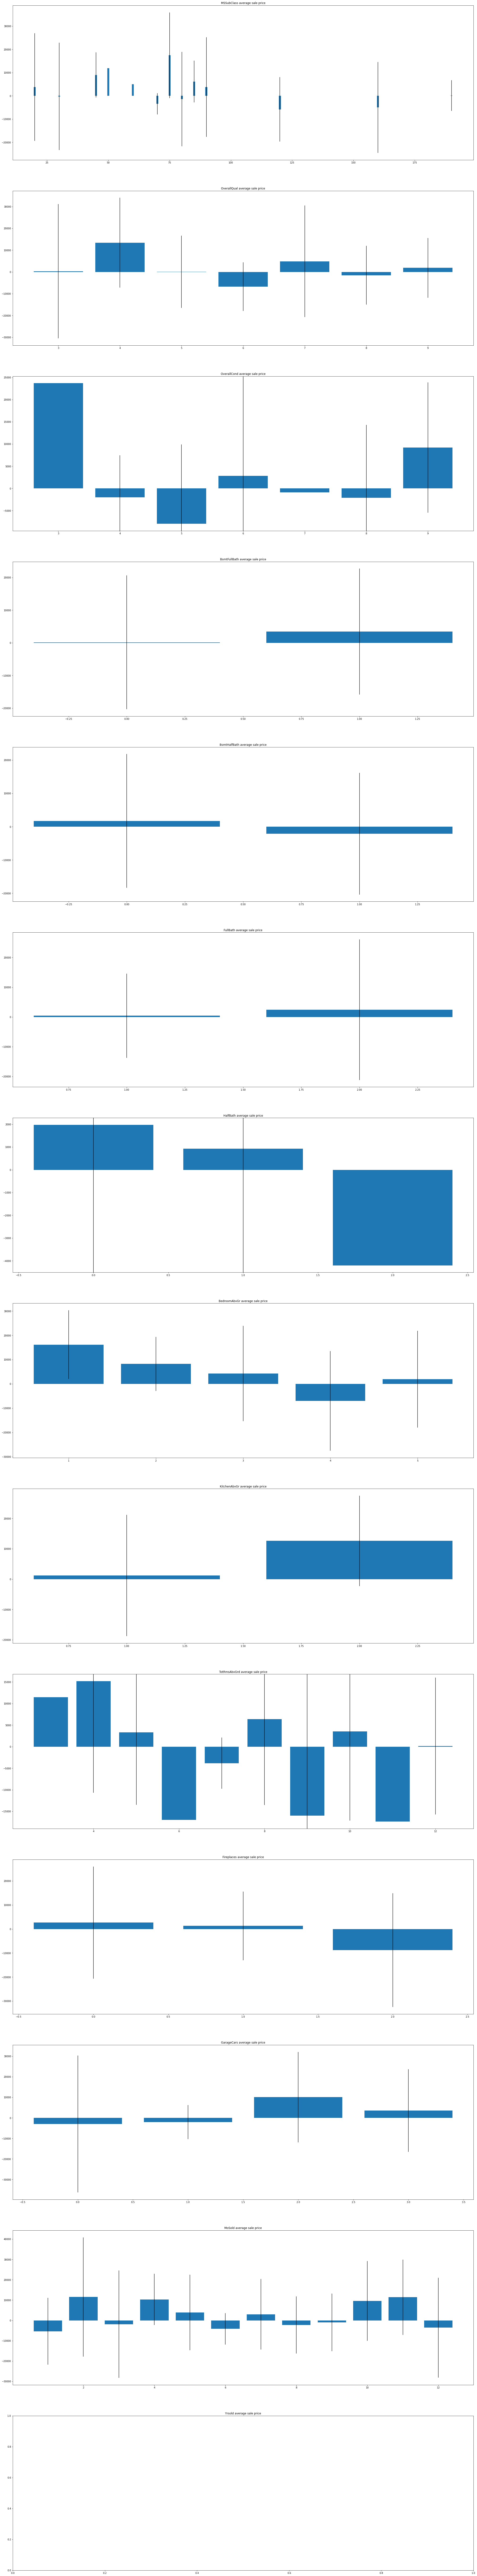

In [405]:
fig, axs = plt.subplots(len(categ),figsize=(35,200))
for i in range(len(categ)):
    bsmt = categ[i]
    axs[i].set_title(bsmt+" average sale price")
    #axs[i].ylabel("Sale price ($)")
    #axs[i].xlabel(bsmt)
    #plt.legend(loc='upper right')
    axs[i].bar(new_df[bsmt].unique(),
        new_df[[bsmt,"SalePrice"]].groupby(bsmt)["SalePrice"].mean(),
        yerr=new_df[[bsmt,"SalePrice"]].groupby(bsmt)["SalePrice"].std());